In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import subspace_angles
from sklearn.decomposition import PCA


def generate_data(n_inliers=100, n_outliers=20, d=3):
   
    
    
    D = d + 1

    
    A = np.random.randn(D, D)
    A1 = np.random.randn(D, D)
    Q, _ = np.linalg.qr(A)
    Q1, _ = np.linalg.qr(A1)

    
    P_inlier = Q[:, :d]  # shape: (D, d)
    P_orth = Q[:,2:]
    P_outlier = Q1[:, d]  # shape: (D,)

   
    inliers = np.random.randn(n_inliers, d)
    inliers_embedded = inliers @ P_inlier.T

    
    outliers = np.random.randn(n_outliers, 1)
    noise = np.random.randn(n_outliers,1)
    outliers = outliers + 0*noise
    outliers_embedded = outliers * P_outlier.reshape(1, -1)

    
    data = np.concatenate([inliers_embedded, outliers_embedded], axis=0)

    
    norms = np.linalg.norm(data, axis=1, keepdims=True)
    data_normalized = data / norms

    return data_normalized, P_inlier,P_orth

In [6]:
def FMS_small2(X, dd, L0):
    D, N = X.shape
    max_iter = 200
    L = L0.copy()
    L_intermediate = {}
    iter_count = 1
    
    
    for iter_count in range(1, max_iter + 1):
        L_old = L.copy()
        
        residual = (np.eye(D) - L @ L.T) @ X
        w = np.maximum(1e-10, np.sqrt(np.sum(residual**2, axis=0)))
        
        # Reweight the data matrix
        XX = X @ np.diag(1.0 / w) @ X.T
        
        # Update L via SVD of the reweighted matrix
        U, _, _ = np.linalg.svd(XX, full_matrices=False)
        L = U[:, :dd]
        
        # Compute a convergence metric (e.g. based on subspace angles)
        ang = np.linalg.norm(subspace_angles(L, L_old))
        
        # Store intermediate L for this iteration
        L_intermediate[iter_count] = L.copy()
        
    return L, L_intermediate


def FMS_large2(X, dd,L0):
    
    D, N = X.shape
    iter_count = 1
    tol=1e-12 
    max_iter=200

    # Initialize using SVD of the raw data
    #U, _, _ = np.linalg.svd(X, full_matrices=False)
    #L = U[:, :dd]
    L = L0


    # Dictionary to store intermediate L values
    L_intermediate = {}

    # Initialize residual angle
    ang = 1

    for iter_count in range(1, max_iter + 1):
        L_old = L.copy()

        # Residual projection onto the orthogonal complement of L
        residual = (np.eye(D) - L @ L.T) @ X

        # Compute weights with a small regularization
        w = np.maximum(1e-3, np.sqrt(np.sum(residual**2, axis=0)))


        # Reweight the data matrix
        XX = X @ np.diag(1.0 / w) @ X.T

        # Update L via SVD of the reweighted matrix
        U, _, _ = np.linalg.svd(XX, full_matrices=False)
        L = U[:, :dd]

        # Compute convergence metric using your subspace_angles function
        ang = np.linalg.norm(subspace_angles(L, L_old))

        L_intermediate[iter_count] = L.copy()

        iter_count += 1

    return L, L_intermediate

def FMS_dc2(X, dd,gamma,L0):
   
    D, N = X.shape
    iter_count = 1
    tol=1e-12 
    max_iter=200
    # Initialize using SVD of the raw data
    #U, _, _ = np.linalg.svd(X, full_matrices=False)
    #L = U[:, :dd]
    L = L0


    residual = (np.eye(D) - L @ L.T) @ X
    distances = np.sqrt(np.sum(residual**2, axis=0))
    epsilon = np.quantile(distances, gamma)

    L_intermediate = {}
    

    # Initialize residual angle
    ang = 1

    for iter_count in range(1, max_iter + 1):
        L_old = L

        # Residual projection onto the orthogonal complement of L
        residual = (np.eye(D) - L_old @ L_old.T) @ X
        distances = np.sqrt(np.sum(residual**2, axis=0))
        
        # Update smoothing parameter: dynamic update based on the gamma-th quantile.
        q_gamma_val = np.quantile(distances, gamma)
        epsilon = min(epsilon, q_gamma_val)
        
        w = np.maximum(epsilon, distances)
       
        # Reweight the data matrix
        XX = X @ np.diag(1.0 / w) @ X.T

        # Update L via SVD of the reweighted matrix
        U, _, _ = np.linalg.svd(XX, full_matrices=False)
        L = U[:, :dd]

        # Compute convergence metric using your subspace_angles function
        ang = np.linalg.norm(subspace_angles(L, L_old))

        L_intermediate[iter_count] = L.copy()

        iter_count += 1

    return L, L_intermediate

np.random.seed(42)
num1 = 100
num2 = 30
d = 3
data, P_true,P_orth = generate_data(n_inliers=num1, n_outliers=num2, d=d)
U, _, _ = np.linalg.svd(data.T, full_matrices=False)
L0 = U[:, :d]  
gamma = 0.5

# Run your methods
P_small, L_small = FMS_small2(data.T, d,L0)   
P_large, L_large = FMS_large2(data.T, d,L0) 
P_dc, L_dc       = FMS_dc2(data.T, d, gamma,L0)    

# Get the keys from each intermediate dictionary
keys_small = set(L_small.keys())
keys_large = set(L_large.keys())
keys_dc    = set(L_dc.keys())

# Compute the intersection of the keys that are common to all three methods
common_keys = sorted(keys_small & keys_large & keys_dc)
m = len(common_keys)

errors1 = np.zeros(m)
errors2 = np.zeros(m)
errors3 = np.zeros(m)

for idx, iter_val in enumerate(common_keys):
    L1 = L_small[iter_val]
    errors1[idx] = np.linalg.norm(L1 @ L1.T - P_true @ P_true.T)
    
    L2 = L_large[iter_val]
    errors2[idx] = np.linalg.norm(L2 @ L2.T - P_true @ P_true.T)
    
    L3 = L_dc[iter_val]
    errors3[idx] = np.linalg.norm(L3 @ L3.T - P_true @ P_true.T)


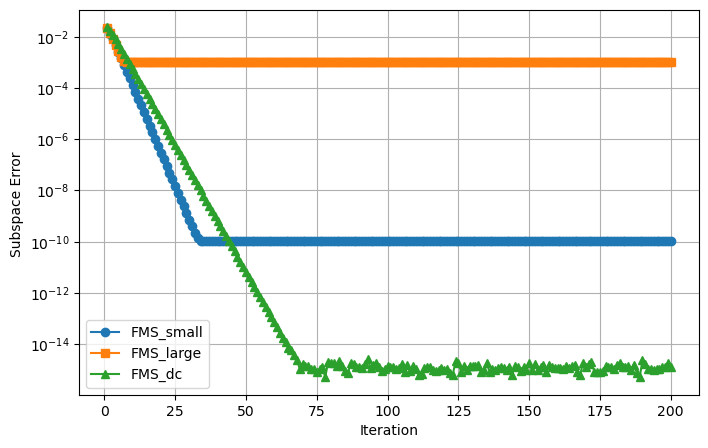

In [11]:

plt.figure(figsize=(8, 5))
plt.plot(common_keys, errors1, marker='o', label='FMS_small')
plt.plot(common_keys, errors2, marker='s', label='FMS_large')
plt.plot(common_keys, errors3, marker='^', label='FMS_dc')
plt.xlabel('Iteration')
plt.ylabel('Subspace Error ')
plt.yscale("log")
#plt.title('Comparison of Subspace Errors at Intermediate Iterations')
plt.legend()
plt.grid(True)
plt.savefig('exp3.png', dpi=300, bbox_inches='tight')
plt.show()